In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.style as mplstyle
%matplotlib inline
mplstyle.use('ggplot')

# Titanic Competition

We'll call this one the belly-flop.

The Kaggle competiton is here: [Titanic](https://www.kaggle.com/c/titanic)

## Read in the data

In [2]:
df = pd.read_csv('data/train.csv')

# Wrangling

In [3]:
df['Sex'] = df['Sex'].astype('category')

In [4]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Distribution of fares

The histogram below shows us that the bulk of passengers paid less than \$100 to board the Titanic. Even then the bulk paid less than $30.

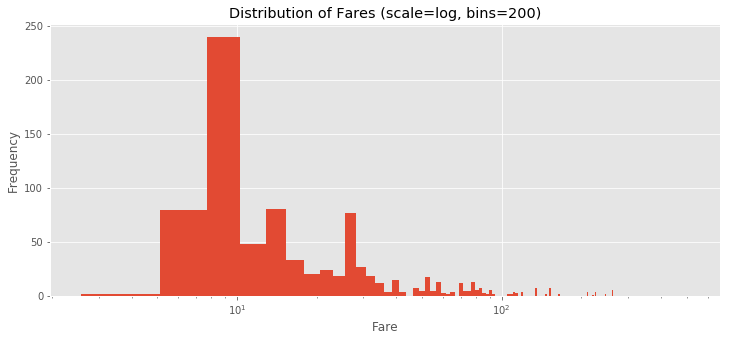

In [5]:
b = 200  # bins

fig, ax = plt.subplots(figsize=(12,5))
df['Fare'].hist(bins=b, ax=ax)
ax.set_title(f'Distribution of Fares (scale=log, bins={b})')
ax.set_xlabel('Fare')
ax.set_ylabel('Frequency')
ax.set_xscale('log')

### Suvival by fare

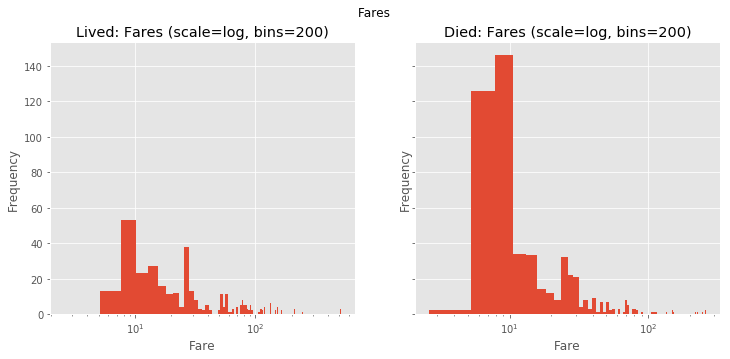

In [6]:
lived = df[df['Survived'] == 1].copy()
died = df[df['Survived'] == 0].copy()
    
b = 200  # bins

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle('Fares')
lived['Fare'].hist(bins=b, ax=ax1)
ax1.set_title(f'Lived: Fares (scale=log, bins={b})')
died['Fare'].hist(bins=100, ax=ax2)
ax2.set_title(f'Died: Fares (scale=log, bins={b})')

for i in (ax1, ax2):
    i.set_ylabel('Frequency')
    i.set_xlabel('Fare')
    i.set_xscale('log')

In [7]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## Distribution of ages

Text(0,0.5,'Frequency')

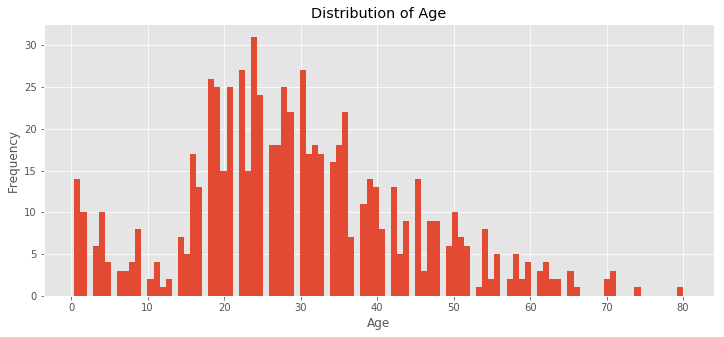

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
df['Age'].hist(bins=100, ax=ax)
ax.set_title('Distribution of Age')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

In [9]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

### Survival by age

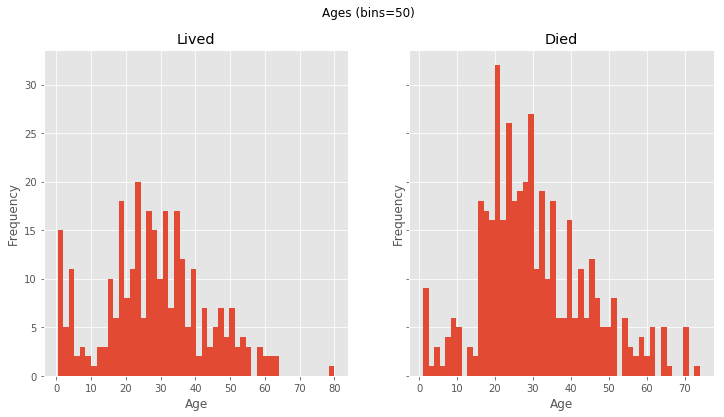

In [10]:
b = 50  # bins

lived = df[df['Survived'] == 1].copy()
died = df[df['Survived'] == 0].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)
fig.suptitle(f'Ages (bins={b})')
lived['Age'].hist(bins=b, ax=ax1)
ax1.set_title('Lived')
died['Age'].hist(bins=b, ax=ax2)
ax2.set_title('Died')
for i in (ax1, ax2):
    i.set_xlabel('Age')
    i.set_ylabel('Frequency')

## Survival by sex

In [11]:
g = df.groupby(['Sex', 'Survived'])
g.size().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


## Exploration

In [12]:
g = lived.groupby(['Sex'])
g.size()

Sex
female    233
male      109
dtype: int64

In [13]:
h = died.groupby(['Sex'])
h.size()

Sex
female     81
male      468
dtype: int64

In [14]:
died.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


# Feature engineering

I'd like to do this:

$$
NewFeature = Normalize(Fare) + Sex
$$

I'm going to use the SciKit Learn `StandardScaler` for this. I don' know why it has to have an index column. Why can't it just take a 1d array?

In [209]:
from sklearn.preprocessing import StandardScaler

In [210]:
scaler = StandardScaler()

# StandardScaler takes 2d arrays, not 1d

data = df[['Fare', 'Survived']]

scaled_data = scaler.fit_transform(data.values)

df1 = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

df1['Sex'] = df['Sex'].astype('category').values.codes

df1 = df1[['Fare', 'Sex']]

In [211]:
# Male = 1, Female = 0
df1.head(2)

,Fare,Sex
0,-0.502445,1
1,0.786845,0


In [212]:
def new_feature_maker(x):
    a, b = x[0], x[1]
    return (b*10 + a*10)/100

In [213]:
df1['NewFeature'] = df1[['Fare', 'Sex']].apply(new_feature_maker, axis=1)

In [214]:
df1['Survived'] = df['Survived']

In [215]:
df1.head()

,Fare,Sex,NewFeature,Survived
0,-0.502445,1,0.049755,0
1,0.786845,0,0.078685,1
2,-0.488854,0,-0.048885,1
3,0.420730,0,0.042073,1
4,-0.486337,1,0.051366,0


In [216]:
def predictor(x):
    if x > 7.5:
        return 0
    return 1

In [217]:
df1['Prediction'] = df1['NewFeature'].apply(predictor)

In [218]:
df1.head()

,Fare,Sex,NewFeature,Survived,Prediction
0,-0.502445,1,0.049755,0,1
1,0.786845,0,0.078685,1,1
2,-0.488854,0,-0.048885,1,1
3,0.420730,0,0.042073,1,1
4,-0.486337,1,0.051366,0,1


In [219]:
g = df1.groupby(['Prediction', 'Survived'])
g.size().unstack()

Survived,0,1
Prediction,,
1,549,342


In [220]:
h = df.groupby(['Sex', 'Survived'])
h.size().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


# Scatterplot

I lost x, y and z. I was using them before but I did my work over again.

They might have been something like

x = fare
y = sex
z = survived

?

In [221]:
survival_colors = ['r', 'b']
colors = pd.Categorical.from_codes(df1['Survived'].values, survival_colors)
colors[:5]

[r, b, b, b, r]
Categories (2, object): [r, b]

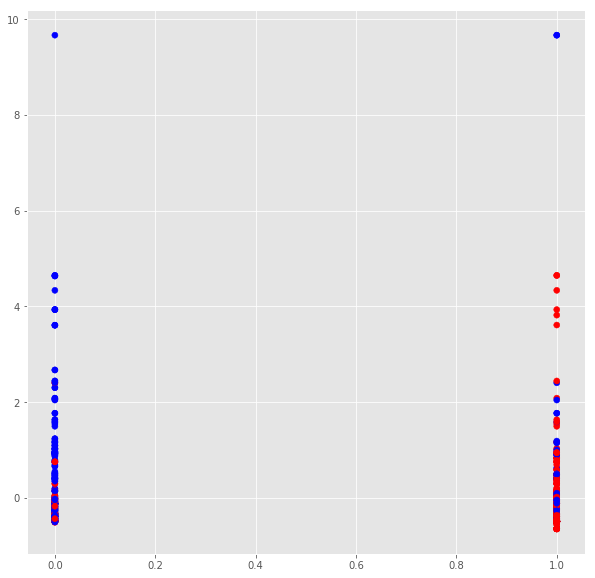

In [222]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(df1['Sex'], df1['Fare'], c=colors)

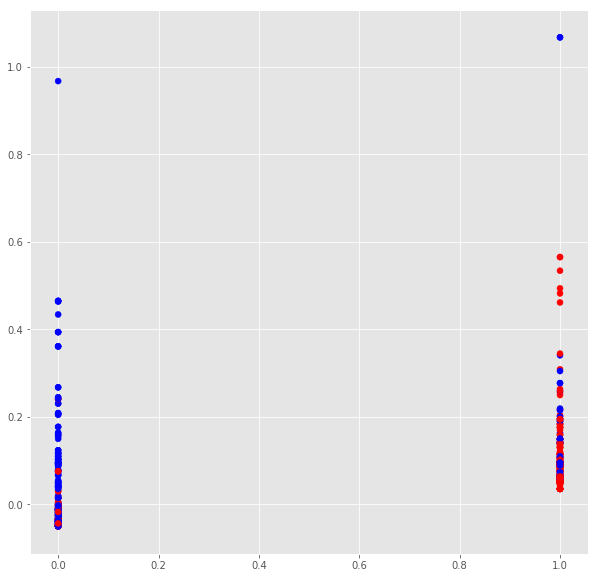

In [223]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(df1['Sex'], df1['NewFeature'], c=colors)

# Appendix A: Columns

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: category(1), float64(2), int64(5), object(4)
memory usage: 77.6+ KB
